In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


import os
import warnings

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input, Embedding, Flatten, Dot, Dense, Concatenate

warnings.filterwarnings('ignore')
%matplotlib inline

from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l2
from tensorflow.keras import layers
#from tensorflow.keras.layers import merge
from tensorflow.keras.layers import Concatenate, Average, Multiply, Dot
from tensorflow.keras.layers import dot



-  I have decided to try the Neural Network model using tensor flow - keras. 
-  Resources: https://towardsdatascience.com/building-a-recommendation-system-using-neural-network-embeddings-1ef92e5c80c9

In [2]:
df_total = pd.read_csv("model_data.csv",index_col = 0)

In [3]:
df_total.head()

,Beer_id,Username_id,User Score
0,84627,30162,3.08
1,84627,11051,3.13
2,84627,24945,4.07
3,84627,30155,3.38
4,84627,30731,4.07


In [4]:
df_total.shape

(678042, 3)

(array([6.7228e+04, 1.2314e+04, 5.2350e+03, 2.9820e+03, 1.1628e+04,
        1.0420e+03, 2.0000e+01, 2.0000e+00, 1.0000e+00, 4.0000e+00]),
 array([ 1. ,  5.9, 10.8, 15.7, 20.6, 25.5, 30.4, 35.3, 40.2, 45.1, 50. ]),
 <a list of 10 Patch objects>)

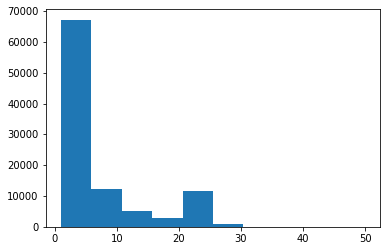

In [5]:
plt.hist(df_total["Beer_id"].value_counts())

In [6]:
df_total.columns = ["beer_id", "User_id", "ratings"]

In [7]:
len(df_total["User_id"].unique())
#36,137 unique users

36137

In [8]:
len(df_total["beer_id"].unique())
# 100,456 beers

100456

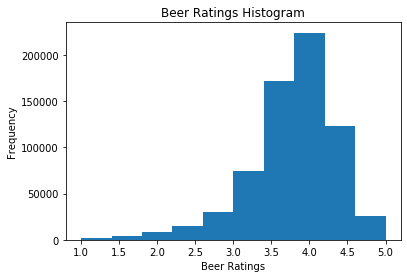

In [9]:
plt.figure()
plt.hist(df_total["ratings"], label = "Beer ratings")
plt.xlabel("Beer Ratings")
plt.ylabel("Frequency")
plt.title("Beer Ratings Histogram")
plt.show()

In [10]:
# Divide the data into train and test

In [11]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df_total, test_size=0.2, random_state=42)

In [12]:
train.head()

,beer_id,User_id,ratings
158326,82212,35328,3.57
110904,28839,32813,5.00
71091,83796,21475,3.51
1225117,100008,31325,3.84
1586167,28853,16469,3.70


In [13]:
test.shape

(135609, 3)

In [14]:
from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l2
from tensorflow.keras import layers
#from tensorflow.keras.layers import merge
from tensorflow.keras.layers import Concatenate, Average, Multiply, Dot
from tensorflow.keras.layers import dot


def embedding_input(name,n_in,n_out,reg):
    inp = Input(shape = (1,), dtype = "int64", name = name)
    return inp, Embedding(n_in,n_out,input_length = 1)(inp)

In [15]:
n_users = df_total.User_id.nunique()
n_beers = df_total.beer_id.nunique()
n_users,n_beers
n_factors = 50

In [16]:
n_users

36137

In [17]:
user_in, u=embedding_input("user_in", n_users,n_factors, 1e-4)
beer_in, m=embedding_input("beer_in",n_beers,n_factors, 1e-4)
m

<tf.Tensor 'embedding_1/embedding_lookup/Identity_1:0' shape=(?, 1, 50) dtype=float32>

In [18]:
x = Dot(axes=1)([u,m])
x = Flatten()(x)
x = Dropout(0.3)(x)
x = Dense(70, activation = "relu")(x)
x = Dropout(0.3)(x)
x = Dense(1)(x)
nn = Model([user_in,beer_in], x)
nn.compile('adam', 'mean_squared_error')

In [19]:
nn.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_in (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
beer_in (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 50)        1806850     user_in[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 50)        5022800     beer_in[0][0]                    
__________________________________________________________________________________________________
dot (Dot) 

In [20]:
from tensorflow.keras.utils import plot_model
plot_model(nn, to_file='model2.png', show_shapes=False, show_layer_names=True,
    rankdir='TB')

In [21]:
from tensorflow.keras.models import load_model

if os.path.exists('regression_model6.h5'):
    nn= load_model('regression_model6.h5')
else:
    history = nn.fit([train.User_id, train.beer_id], train.ratings, epochs=5, verbose=1)
    nn.save('regression_model6.h5')
    plt.plot(history.history['loss'])
    plt.xlabel("Epochs")
    plt.ylabel("Training Error")

In [22]:
nn.evaluate([test.User_id, test.beer_id], test.ratings)

135609/135609 [==============================] - 12s 92us/step


0.20336864221379888

In [23]:
predictions2 = nn.predict([test.User_id, test.beer_id])

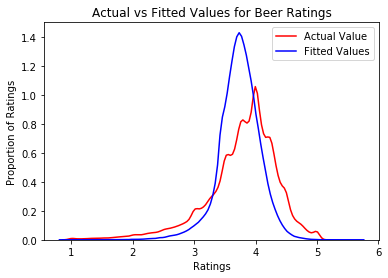

In [24]:
import seaborn as sns
plt.figure()


ax1 = sns.distplot(test.ratings, hist=False, color="r", label="Actual Value")
sns.distplot(predictions2, hist=False, color="b", label="Fitted Values" , ax=ax1)


plt.title('Actual vs Fitted Values for Beer Ratings')
plt.xlabel('Ratings')
plt.ylabel('Proportion of Ratings')

plt.show()
plt.close()

In [25]:
test["predictions"] = predictions2
test.head()

,beer_id,User_id,ratings,predictions
1616353,15105,33888,3.20,3.373137
623057,67997,577,3.58,3.603600
58326,67978,21186,4.13,3.711141
123986,66558,10237,3.90,4.058798
1284410,53711,18820,3.12,3.723207


In [26]:
import recmetrics
import matplotlib.pyplot as plt

In [27]:
print("Mean Squared error is:")
print(recmetrics.mse(test.ratings, test.predictions))
print("Root Mean Squared Error is:")
print(recmetrics.rmse(test.ratings, test.predictions))

Mean Squared error is:
0.20336864066146781
Root Mean Squared Error is:
0.45096412347488113


### EMBEDDINGS FOR COLD START - TOTAL DF

In [28]:
# Extract embeddings

beer_em = nn.get_layer('embedding_1')
beer_em_weights = beer_em.get_weights()[0]



beer_em_weights.shape
beer_em_weights

array([[ 0.74344677,  0.21334958,  0.776332  , ...,  0.45663404,
         0.8287164 ,  0.37052646],
       [ 0.8879351 ,  0.7393564 ,  0.4285744 , ...,  0.8972289 ,
         0.83515596,  0.9513305 ],
       [ 0.6018248 ,  0.5453577 ,  0.22619922, ...,  1.1452312 ,
         0.5874955 ,  0.48767838],
       ...,
       [ 1.2791545 ,  0.33989736,  1.0978934 , ...,  0.55807465,
         0.9202401 ,  0.86311877],
       [ 0.42791578,  1.037834  ,  0.25275815, ...,  0.6495895 ,
         0.6380083 ,  0.99765706],
       [-0.23147924,  0.7492978 ,  0.18874146, ..., -0.11552278,
        -0.03197143,  0.2583404 ]], dtype=float32)

In [29]:
#Each beer is now represented as a 50-dimensional vector.
# We need to normalize the embeddings so that the dot product between two embeddings becomes the cosine similarity.
#source = https://towardsdatascience.com/building-a-recommendation-system-using-neural-network-embeddings-1ef92e5c80c9
beer_em_weights = beer_em_weights / np.linalg.norm(beer_em_weights, axis = 1).reshape((-1, 1))
beer_em_weights[0][:10]
np.sum(np.square(beer_em_weights[100]))

0.99999994

In [30]:
beer_id_em = df_total["beer_id"].unique()
beer_id_em

array([84627, 48359, 70931, ..., 94148, 96146, 20023], dtype=int64)

In [31]:
beer_pd = pd.DataFrame(beer_em_weights)
beer_pd["beer_id"] = beer_id_em
beer_pd = beer_pd.set_index("beer_id")
beer_pd.head()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
beer_id,,,,,,,,,,,,,,,,,,,,,
84627,0.165913,0.047613,0.173252,0.127195,0.065180,0.218318,0.032207,0.097739,0.148118,0.198845,...,0.080858,0.103122,0.149452,0.068352,0.109492,0.194746,0.110312,0.101906,0.184942,0.082689
48359,0.179784,0.149701,0.086775,0.120444,0.120256,0.170227,0.153406,0.110601,0.186355,0.080455,...,0.141834,0.115630,0.075467,0.127683,0.101700,0.114788,0.033853,0.181666,0.169098,0.192620
70931,0.112803,0.102219,0.042398,0.046837,0.094003,0.199456,0.175573,0.126572,0.108145,0.186079,...,0.163171,0.149580,0.053876,0.089760,0.134415,0.179341,0.120688,0.214656,0.110117,0.091408
97050,-0.007938,0.158076,0.113604,0.235478,0.202546,0.215729,0.009759,0.008170,0.170948,0.014073,...,0.104021,0.122394,0.231554,-0.039201,-0.037381,0.223322,0.013763,0.267003,0.020030,0.212583
64399,0.166376,0.229141,0.014912,0.087396,0.196742,0.061704,0.042234,0.035216,0.034856,0.024434,...,0.161381,0.041168,0.136571,0.032709,0.085681,0.152440,0.226030,0.185516,0.187600,0.166137


In [32]:
beer_df = pd.read_csv("total_df.csv",index_col = 0)

In [33]:
beer_df.columns

Index(['URL', 'Beer name', 'Brewery', 'Style', 'Style_Ranked', 'ABV', 'Score',
       'Score_Ranked', 'Avg Rating', 'Reviews', 'N_Ratings', 'Brewery_Name',
       'Brewery_City', 'Brewery_Country', 'Availability', 'N_Wants', 'N_Gots',
       'User Score', 'User_ratings', 'User comment', 'Username', 'Date Review',
       'Look_rating', 'Smell_rating', 'tasting_rating', 'feel_rating',
       'overall_rating', 'Username_id', 'Date of Review', 'Beer + Brewery',
       'Beer_id'],
      dtype='object')

In [34]:
names_beer = beer_df[["Beer_id","Beer + Brewery","Beer name"]].copy()

In [35]:
names_beer.columns = ['beer_id', 'Beer + Brewery', "Beer name"]

In [36]:
names_beer  = names_beer.drop_duplicates()

In [37]:
names_beer.shape

(100456, 3)

In [38]:
beer_pd.shape

(100456, 50)

In [39]:
names_beer.columns

Index(['beer_id', 'Beer + Brewery', 'Beer name'], dtype='object')

In [40]:
beer_pd.shape

(100456, 50)

In [41]:
beer_pd = beer_pd.reset_index()

In [42]:
beer_pd.columns

Index(['beer_id',         0,         1,         2,         3,         4,
               5,         6,         7,         8,         9,        10,
              11,        12,        13,        14,        15,        16,
              17,        18,        19,        20,        21,        22,
              23,        24,        25,        26,        27,        28,
              29,        30,        31,        32,        33,        34,
              35,        36,        37,        38,        39,        40,
              41,        42,        43,        44,        45,        46,
              47,        48,        49],
      dtype='object')

In [43]:
beers_embeddings = pd.merge(beer_pd, names_beer, on= "beer_id", how = "left")

In [44]:
beers_embeddings.columns

Index([       'beer_id',                0,                1,                2,
                      3,                4,                5,                6,
                      7,                8,                9,               10,
                     11,               12,               13,               14,
                     15,               16,               17,               18,
                     19,               20,               21,               22,
                     23,               24,               25,               26,
                     27,               28,               29,               30,
                     31,               32,               33,               34,
                     35,               36,               37,               38,
                     39,               40,               41,               42,
                     43,               44,               45,               46,
                     47,               48,          

In [45]:
beers_embeddings[beers_embeddings["Beer name"].str.contains("Heineken")]

,beer_id,0,1,2,3,4,5,6,7,8,...,42,43,44,45,46,47,48,49,Beer + Brewery,Beer name
38453,40157,0.221580,0.176081,0.068015,-0.039921,0.173916,0.061939,0.004534,0.110257,0.287793,...,0.225861,0.098091,-0.025094,0.115013,0.171114,0.222144,0.177802,0.237336,Heineken Oud Bruin - Heineken Nederland B.V.,Heineken Oud Bruin
39128,40155,0.196359,0.135998,0.209365,0.118793,0.123844,0.082347,0.179259,0.111777,0.233410,...,0.103434,0.114089,0.211856,-0.010184,0.127575,0.141926,0.104199,0.152292,Heineken Dark Lager - Heineken Nederland B.V.,Heineken Dark Lager
69996,40158,0.183716,0.119907,0.218755,0.191543,0.102580,0.074697,0.132290,0.137247,0.133924,...,0.069532,0.139779,0.060056,0.055912,0.046553,0.213505,0.153156,0.192140,Heineken Premium Light Lager - Heineken Nederl...,Heineken Premium Light Lager
72376,40156,0.071487,0.214702,0.219067,0.135198,0.182828,0.155283,0.156016,0.057689,0.197032,...,0.161810,0.198700,0.035092,0.080211,0.136143,0.034364,0.108265,0.231536,Heineken Lager Beer - Heineken Romania,Heineken Lager Beer
80885,40154,0.179649,-0.006748,0.121628,0.203417,0.038585,0.105609,0.166274,0.065853,0.118197,...,0.202567,0.032333,0.229942,0.071348,0.026373,-0.005635,0.177124,0.244537,Heineken 0.0 - Heineken Nederland B.V.,Heineken 0.0
97602,40159,0.016557,0.014924,0.078946,0.213023,0.107666,0.090180,0.279991,-0.003167,-0.004146,...,0.216294,0.047442,0.096861,0.169136,0.102039,0.027916,0.119534,0.007565,Heineken Tarwebok - Heineken Nederland B.V.,Heineken Tarwebok


In [46]:
beers_embeddings.iloc[:,1:51]

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,0.165913,0.047613,0.173252,0.127195,0.065180,0.218318,0.032207,0.097739,0.148118,0.198845,...,0.080858,0.103122,0.149452,0.068352,0.109492,0.194746,0.110312,0.101906,0.184942,0.082689
1,0.179784,0.149701,0.086775,0.120444,0.120256,0.170227,0.153406,0.110601,0.186355,0.080455,...,0.141834,0.115630,0.075467,0.127683,0.101700,0.114788,0.033853,0.181666,0.169098,0.192620
2,0.112803,0.102219,0.042398,0.046837,0.094003,0.199456,0.175573,0.126572,0.108145,0.186079,...,0.163171,0.149580,0.053876,0.089760,0.134415,0.179341,0.120688,0.214656,0.110117,0.091408
3,-0.007938,0.158076,0.113604,0.235478,0.202546,0.215729,0.009759,0.008170,0.170948,0.014073,...,0.104021,0.122394,0.231554,-0.039201,-0.037381,0.223322,0.013763,0.267003,0.020030,0.212583
4,0.166376,0.229141,0.014912,0.087396,0.196742,0.061704,0.042234,0.035216,0.034856,0.024434,...,0.161381,0.041168,0.136571,0.032709,0.085681,0.152440,0.226030,0.185516,0.187600,0.166137
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100451,0.092181,0.050747,0.053371,0.147189,0.051818,0.044338,0.024059,0.190047,0.058231,0.022852,...,0.209048,0.043125,0.095122,0.037622,0.229960,0.121892,0.084229,0.098015,0.218076,0.207656
100452,0.225032,0.022504,0.017671,-0.024075,0.232343,0.202135,0.199186,0.235660,0.199912,-0.011195,...,-0.031711,0.198274,0.047248,0.014820,-0.001332,0.127503,0.133409,-0.009285,0.063598,0.161574
100453,0.199955,0.053132,0.171621,0.196483,0.115337,0.064615,0.120304,0.108796,0.180460,0.168661,...,0.166624,0.083468,0.092449,0.147393,0.128977,0.196654,0.080895,0.087237,0.143850,0.134921
100454,0.097956,0.237574,0.057860,0.103317,0.200601,0.216823,0.131832,0.067842,0.174149,0.169984,...,0.112919,0.115010,0.174561,0.053930,0.136760,0.106240,0.124430,0.148700,0.146048,0.228377


In [47]:
def find_similarity_total(beer_name):
    """Recommends beers based on the cosine similarity between beers"""
    cosine_list_total = []
    beer_name3 = []
    beer_name4 = []

    for i in range(0,beers_embeddings.shape[0]):
        tent4 = beers_embeddings.iloc[i,1:51]
        tent5 = beers_embeddings[beers_embeddings["Beer name"] == beer_name]
        tent6 = tent5.iloc[0,1:51]
        cosine_total = np.dot(tent6,tent4)
        
        beer3 = tent5.iloc[0,52]
        beer4 = beers_embeddings.iloc[i,52]
        cosine_list_total.append(cosine_total)
        beer_name3.append(beer3)
        beer_name4.append(beer4)
        
        
    cosine_df_total = pd.DataFrame({"beer1" : beer_name3, "beer2" : beer_name4, "cosine" : cosine_list_total})
    cosine_df_total = cosine_df_total.sort_values(by="cosine", ascending = False)
    return cosine_df_total.head(10)

 - This function takes a lot of time to recommend beers, it takes the dot product of every possible combination with the beer chosen and gives the cosine similarity. 
 - Based on that, I have decided to use BC Local Beers to recommend for new users!

In [48]:
#find_similarity_total("Kalik")


### BC LOCAL BEERS RECOMMENDATIONS - COLD START

In [49]:
bc = pd.read_csv("beer_bc.csv", index_col = 0)

In [50]:
bc.shape

(18241, 31)

In [51]:
bc.head()

,URL,Beer name,Brewery,Style,Style_Ranked,ABV,Score,Score_Ranked,Avg Rating,Reviews,...,Date Review,Look_rating,Smell_rating,tasting_rating,feel_rating,overall_rating,Username_id,Date of Review,Beer + Brewery,Beer_id
943,https://www.beeradvocate.com/beer/profile/3822...,Biere De Garde,Strange Fellows Brewing,French Bière de Garde,0.0,6.0,85.175407,0.0,3.83,1,...,"Dec 29, 2014",4.5,3.75,3.50,4.00,3.75,16159,2014-12-29,Biere De Garde - Strange Fellows Brewing,9609
1743,https://www.beeradvocate.com/beer/profile/2937...,Brews Brothers Hangin' Tough (Red Bock),Parallel 49 Brewing Company,German Bock,0.0,7.0,85.175407,0.0,3.52,2,...,"Oct 11, 2019",3.5,3.50,3.75,3.75,3.75,6455,2019-10-11,Brews Brothers Hangin' Tough (Red Bock) - Para...,14633
1750,https://www.beeradvocate.com/beer/profile/2937...,Brews Brothers Hangin' Tough (Red Bock),Parallel 49 Brewing Company,German Bock,0.0,7.0,85.175407,0.0,3.52,2,...,"Jun 05, 2019",3.0,3.00,3.00,3.00,4.00,20983,2019-06-05,Brews Brothers Hangin' Tough (Red Bock) - Para...,14633
2104,https://www.beeradvocate.com/beer/profile/6272...,Bavarian Copper Bock,CANOE Brewpub,German Bock,0.0,6.5,85.175407,0.0,4.00,2,...,"Oct 21, 2010",4.0,4.00,4.50,4.00,5.00,32472,2010-10-21,Bavarian Copper Bock - CANOE Brewpub,7943
2110,https://www.beeradvocate.com/beer/profile/6272...,Bavarian Copper Bock,CANOE Brewpub,German Bock,0.0,6.5,85.175407,0.0,4.00,2,...,"Aug 13, 2009",4.0,4.50,4.00,4.00,4.00,19721,2009-08-13,Bavarian Copper Bock - CANOE Brewpub,7943


In [52]:
info_bc_beers = bc[["Beer_id", "Beer name", "Brewery",'Style', 
       'ABV', 'Score', 'Avg Rating', 'N_Ratings',
       'Brewery_Name', 'Brewery_City', 'Brewery_Country', 'Availability',
       'N_Wants', 'N_Gots',]].copy()

In [53]:
info_bc_beers = info_bc_beers.drop_duplicates()

In [54]:
info_bc_beers.shape

(1522, 14)

In [55]:
info_bc_beers.head()

,Beer_id,Beer name,Brewery,Style,ABV,Score,Avg Rating,N_Ratings,Brewery_Name,Brewery_City,Brewery_Country,Availability,N_Wants,N_Gots
943,9609,Biere De Garde,Strange Fellows Brewing,French Bière de Garde,6.0,85.175407,3.83,3,Strange Fellows Brewing,British Columbia,Canada,Rotating,0,0
1743,14633,Brews Brothers Hangin' Tough (Red Bock),Parallel 49 Brewing Company,German Bock,7.0,85.175407,3.52,3,Parallel 49 Brewing Company,British Columbia,Canada,One-off,0,0
2104,7943,Bavarian Copper Bock,CANOE Brewpub,German Bock,6.5,85.175407,4.00,5,CANOE Brewpub,British Columbia,Canada,Rotating,0,0
4593,619,1897 Amber Ale,Stanley Park Brewery,Belgian Pale Ale,5.1,77.000000,3.29,74,Stanley Park Brewery,British Columbia,Canada,Year-round,1,18
5660,8165,Bear Paw Honey Lager,Whistler Brewing Company,American Adjunct Lager,5.0,73.000000,3.46,78,Whistler Brewing Company,British Columbia,Canada,Year-round,5,24


In [56]:
info_bc_beers.shape

(1522, 14)

In [57]:
info_bc_beers.columns

Index(['Beer_id', 'Beer name', 'Brewery', 'Style', 'ABV', 'Score',
       'Avg Rating', 'N_Ratings', 'Brewery_Name', 'Brewery_City',
       'Brewery_Country', 'Availability', 'N_Wants', 'N_Gots'],
      dtype='object')

In [58]:
info_bc_beers.columns = ['beer_id', 'Beer name', 'Brewery', 'Style', 'ABV', 'Score',
       'Avg Rating', 'N_Ratings', 'Brewery_Name', 'Brewery_City',
       'Brewery_Country', 'Availability', 'N_Wants', 'N_Gots']

In [59]:
bc_beers_exploration = pd.merge(info_bc_beers,beers_embeddings, how = "left", on = "beer_id")

In [60]:
bc_beers_exploration.columns

Index([        'beer_id',     'Beer name_x',         'Brewery',
                 'Style',             'ABV',           'Score',
            'Avg Rating',       'N_Ratings',    'Brewery_Name',
          'Brewery_City', 'Brewery_Country',    'Availability',
               'N_Wants',          'N_Gots',                 0,
                       1,                 2,                 3,
                       4,                 5,                 6,
                       7,                 8,                 9,
                      10,                11,                12,
                      13,                14,                15,
                      16,                17,                18,
                      19,                20,                21,
                      22,                23,                24,
                      25,                26,                27,
                      28,                29,                30,
                      31,               

In [61]:
bc_beers_exploration.drop('N_Gots',axis = 1, inplace = True)
bc_beers_exploration.drop('N_Wants',axis = 1, inplace = True)
bc_beers_exploration.drop('Avg Rating',axis = 1, inplace = True)
bc_beers_exploration.drop('N_Ratings',axis = 1, inplace = True)


In [62]:
bc_beers_exploration[bc_beers_exploration["Beer name_x"].str.contains("Original")]

,beer_id,Beer name_x,Brewery,Style,ABV,Score,Brewery_Name,Brewery_City,Brewery_Country,Availability,...,42,43,44,45,46,47,48,49,Beer + Brewery,Beer name_y
203,64956,Original Gravity Haze,Driftwood Brewery,New England IPA,7.0,85.175407,Driftwood Brewery,British Columbia,Canada,Rotating,...,-0.000247,0.113483,0.143018,0.138662,0.136150,0.117810,0.103413,0.209892,Original Gravity Haze - Driftwood Brewery,Original Gravity Haze
358,64974,Original Pale Ale,Spinnakers Gastro Brewpub & Guesthouse,English Pale Ale,5.0,80.000000,Spinnakers Gastro Brewpub & Guesthouse,British Columbia,Canada,Rotating,...,0.019391,0.220452,0.175504,0.172911,0.052967,0.036433,0.154337,0.189932,Original Pale Ale - Spinnakers Gastro Brewpub ...,Original Pale Ale
1509,64956,Original Gravity Haze,Driftwood Brewery,New England IPA,7.0,85.175407,Driftwood Brewery,British Columbia,Canada,Rotating,...,-0.000247,0.113483,0.143018,0.138662,0.136150,0.117810,0.103413,0.209892,Original Gravity Haze - Driftwood Brewery,Original Gravity Haze


In [63]:
bc_beers_exploration.columns

Index([        'beer_id',     'Beer name_x',         'Brewery',
                 'Style',             'ABV',           'Score',
          'Brewery_Name',    'Brewery_City', 'Brewery_Country',
          'Availability',                 0,                 1,
                       2,                 3,                 4,
                       5,                 6,                 7,
                       8,                 9,                10,
                      11,                12,                13,
                      14,                15,                16,
                      17,                18,                19,
                      20,                21,                22,
                      23,                24,                25,
                      26,                27,                28,
                      29,                30,                31,
                      32,                33,                34,
                      35,               

In [64]:
bc_beers_exploration = bc_beers_exploration.drop_duplicates()

In [65]:
bc_beers_exploration.shape

(1490, 62)

In [66]:
bc_beers_exploration.iloc[:,1]

0                                Biere De Garde
1       Brews Brothers Hangin' Tough (Red Bock)
2                          Bavarian Copper Bock
3                                1897 Amber Ale
4                          Bear Paw Honey Lager
                         ...                   
1506                                  Dat Juice
1508     Haulin' Some Mass New England Hazy IPA
1513                    Please Sir S’more Stout
1514                            The Crawl Stout
1517                                 Potts Pils
Name: Beer name_x, Length: 1490, dtype: object

In [67]:
bc_beers_exploration.shape[0]

1490

In [68]:
bc_beers_exploration.iloc[1,10:60]

0      0.224072
1      0.170482
2      0.163907
3      0.158978
4      0.060176
5      0.151671
6      0.110635
7     0.0874626
8      0.190048
9      0.100788
10      0.13431
11    0.0258912
12     0.216229
13     0.122845
14    0.0773279
15     0.157122
16     0.178249
17     0.143646
18    0.0474493
19     0.224847
20     0.106929
21    0.0449149
22    0.0633994
23    0.0645722
24    0.0401176
25    0.0370893
26     0.203411
27     0.206438
28    0.0628882
29     0.228188
30     0.133797
31     0.100912
32      0.18005
33    0.0391986
34     0.157237
35     0.121564
36     0.103984
37     0.197735
38    0.0706153
39     0.176708
40    0.0856668
41     0.178556
42     0.210496
43     0.188466
44    0.0306864
45    0.0398243
46     0.189536
47     0.147683
48    0.0226907
49     0.165004
Name: 1, dtype: object

In [69]:
bc_beers_exploration.to_csv("bc_beers_final.csv")

In [70]:
def find_similarity(beer_name):
    """Recommends beers based on the cosine similarity between beers - BC Beers only"""
    cosine_list = []
    beer_name1 = []
    beer_name2 = []

    for i in range(0,bc_beers_exploration.shape[0]):
        tent1 = bc_beers_exploration.iloc[i,10:60]
        tent2 = bc_beers_exploration[bc_beers_exploration["Beer name_x"] == beer_name]
        tent3 = tent2.iloc[0,10:60]
        cosine = np.dot(tent3,tent1)
        
        beer1 = tent2.iloc[0,1]
        beer2 = bc_beers_exploration.iloc[i,1]
        cosine_list.append(cosine)
        beer_name1.append(beer1)
        beer_name2.append(beer2)
        
        
    cosine_df = pd.DataFrame({"beer1" : beer_name1, "beer2" : beer_name2, "cosine" : cosine_list})
    cosine_df = cosine_df.sort_values(by="cosine", ascending = False)
    
    return cosine_df.iloc[1:11,:]


In [71]:
find_similarity("Belgian Pale Ale")

,beer1,beer2,cosine
360,Belgian Pale Ale,Lord Nelson's Pale Ale,0.890184
1437,Belgian Pale Ale,Chocolate Mint Brown Ale,0.887821
1312,Belgian Pale Ale,Nasty Habit IPA,0.878563
331,Belgian Pale Ale,Zunga,0.876150
652,Belgian Pale Ale,Psychosis 7 Double IPA,0.875824
1388,Belgian Pale Ale,West Coast IPA,0.874363
699,Belgian Pale Ale,Year Of The Unicorn,0.869870
1275,Belgian Pale Ale,Citradelic,0.868480
1110,Belgian Pale Ale,Mt. Prevost Porter,0.867938
824,Belgian Pale Ale,Goodnight Sweet Prince,0.865653


In [72]:
bc_beers_exploration.head()

,beer_id,Beer name_x,Brewery,Style,ABV,Score,Brewery_Name,Brewery_City,Brewery_Country,Availability,...,42,43,44,45,46,47,48,49,Beer + Brewery,Beer name_y
0,9609,Biere De Garde,Strange Fellows Brewing,French Bière de Garde,6.0,85.175407,Strange Fellows Brewing,British Columbia,Canada,Rotating,...,-0.043168,-0.027171,0.141263,0.180186,-0.069818,-0.098702,0.221338,0.011320,Biere De Garde - Strange Fellows Brewing,Biere De Garde
1,14633,Brews Brothers Hangin' Tough (Red Bock),Parallel 49 Brewing Company,German Bock,7.0,85.175407,Parallel 49 Brewing Company,British Columbia,Canada,One-off,...,0.210496,0.188466,0.030686,0.039824,0.189536,0.147683,0.022691,0.165004,Brews Brothers Hangin' Tough (Red Bock) - Para...,Brews Brothers Hangin' Tough (Red Bock)
2,7943,Bavarian Copper Bock,CANOE Brewpub,German Bock,6.5,85.175407,CANOE Brewpub,British Columbia,Canada,Rotating,...,0.084515,0.043492,-0.016339,0.231458,0.182410,0.253689,0.182420,0.205988,Bavarian Copper Bock - CANOE Brewpub,Bavarian Copper Bock
3,619,1897 Amber Ale,Stanley Park Brewery,Belgian Pale Ale,5.1,77.000000,Stanley Park Brewery,British Columbia,Canada,Year-round,...,0.151326,0.056290,0.025795,0.134799,0.146627,0.186816,0.225694,0.062402,1897 Amber Ale - Stanley Park Brewery,1897 Amber Ale
4,8165,Bear Paw Honey Lager,Whistler Brewing Company,American Adjunct Lager,5.0,73.000000,Whistler Brewing Company,British Columbia,Canada,Year-round,...,0.107274,0.127383,0.035540,0.153133,0.111051,0.050091,0.173319,0.091482,Bear Paw Honey Lager - Whistler Brewing Company,Bear Paw Honey Lager


 - Savings embeddings to use the Google Embedding Projector
    https://projector.tensorflow.org/

In [73]:
beers_for_embedding_project = bc_beers_exploration.iloc[:,10:60]

In [74]:
label_for_embedding_project = bc_beers_exploration.iloc[:,1]

In [75]:
label_for_embedding_project

0                                Biere De Garde
1       Brews Brothers Hangin' Tough (Red Bock)
2                          Bavarian Copper Bock
3                                1897 Amber Ale
4                          Bear Paw Honey Lager
                         ...                   
1506                                  Dat Juice
1508     Haulin' Some Mass New England Hazy IPA
1513                    Please Sir S’more Stout
1514                            The Crawl Stout
1517                                 Potts Pils
Name: Beer name_x, Length: 1490, dtype: object

In [76]:
style_for_embedding_project = bc_beers_exploration.iloc[:,3]
style_for_embedding_project

0         French Bière de Garde
1                   German Bock
2                   German Bock
3              Belgian Pale Ale
4        American Adjunct Lager
                 ...           
1506    American Pale Ale (APA)
1508            New England IPA
1513    American Imperial Stout
1514             American Stout
1517             German Pilsner
Name: Style, Length: 1490, dtype: object

In [77]:
#beers_for_embedding_project.to_csv("weights2.tsv",sep='\t', encoding='utf-8')

In [78]:
#label_for_embedding_project.to_csv("labels2.tsv",sep='\t', encoding='utf-8')

In [79]:
#style_for_embedding_project.to_csv("style.tsv",sep='\t', encoding='utf-8')

### RECOMMENDATION FOR CURRENT USERS

In [80]:
df_total.columns

Index(['beer_id', 'User_id', 'ratings'], dtype='object')

In [81]:
beer_df.head()

,URL,Beer name,Brewery,Style,Style_Ranked,ABV,Score,Score_Ranked,Avg Rating,Reviews,...,Date Review,Look_rating,Smell_rating,tasting_rating,feel_rating,overall_rating,Username_id,Date of Review,Beer + Brewery,Beer_id
0,https://www.beeradvocate.com/beer/profile/150/...,Stegmaier Brewhouse Bock,"Lion Brewery, Inc.",German Bock,39.0,6.6,84.0,0.0,3.76,49,...,"Sep 19, 2011",3.5,3.0,3.0,3.5,3.0,30162,2011-09-19,"Stegmaier Brewhouse Bock - Lion Brewery, Inc.",84627
1,https://www.beeradvocate.com/beer/profile/150/...,Stegmaier Brewhouse Bock,"Lion Brewery, Inc.",German Bock,39.0,6.6,84.0,0.0,3.76,49,...,"Jun 11, 2011",3.5,3.0,3.0,3.0,3.5,11051,2011-06-11,"Stegmaier Brewhouse Bock - Lion Brewery, Inc.",84627
2,https://www.beeradvocate.com/beer/profile/150/...,Stegmaier Brewhouse Bock,"Lion Brewery, Inc.",German Bock,39.0,6.6,84.0,0.0,3.76,49,...,"Sep 29, 2010",3.5,4.0,4.0,4.0,4.5,24945,2010-09-29,"Stegmaier Brewhouse Bock - Lion Brewery, Inc.",84627
3,https://www.beeradvocate.com/beer/profile/150/...,Stegmaier Brewhouse Bock,"Lion Brewery, Inc.",German Bock,39.0,6.6,84.0,0.0,3.76,49,...,"Jun 29, 2010",3.5,3.0,3.5,3.5,3.5,30155,2010-06-29,"Stegmaier Brewhouse Bock - Lion Brewery, Inc.",84627
4,https://www.beeradvocate.com/beer/profile/150/...,Stegmaier Brewhouse Bock,"Lion Brewery, Inc.",German Bock,39.0,6.6,84.0,0.0,3.76,49,...,"May 25, 2010",3.5,4.0,4.0,4.0,4.5,30731,2010-05-25,"Stegmaier Brewhouse Bock - Lion Brewery, Inc.",84627


In [82]:
beer_df.shape

(1448216, 31)

In [83]:
all_beers = beer_df.iloc[:,30]
all_beers = df_total["beer_id"].unique()

In [84]:
all_users = beer_df["Username_id"].unique()
beer_df["Username_id"].nunique()

36137

In [85]:
all_users.shape

(36137,)

In [86]:
df_total.head()

,beer_id,User_id,ratings
0,84627,30162,3.08
1,84627,11051,3.13
2,84627,24945,4.07
3,84627,30155,3.38
4,84627,30731,4.07


In [87]:
beer_total = beer_df[['Beer name','Brewery', 'Style','ABV', "Beer_id"]].copy()
beer_total = beer_total.drop_duplicates()

In [88]:
def recommend(user_name):
    usernames = []
    beer_name2 = []
    ratings_list = []
    all_beers = df_total["beer_id"].unique()

    dataset = df_total.loc[df_total["User_id"] == user_name]
    trial = dataset["beer_id"].unique()
    
    
    for beer in all_beers:
        if beer in trial:
            continue
        else:
            usernames.append(user_name)
            beer_name2.append(beer)
    
    
    list_data = pd.DataFrame({"Beer_id" : beer_name2, "User" : usernames})
    ratings = nn.predict([list_data.User,list_data.Beer_id])
    ratings_list.append(ratings)
    
    list_data["ratings"] = ratings
    list_data = list_data.sort_values(by = "ratings", ascending = False)
    list_data_total = list_data.merge(beer_total, on= "Beer_id", how = "left")
    recommendation = list_data_total[["Beer_id","Beer name", "Brewery", "Style", "ABV", "ratings"]].copy()
    recommendation.columns = [ "Beer_id","Beer", "Brewery", "Style", "ABV", "Ratings"]
    recommendation = recommendation.sort_values(by = "Ratings",ascending = False)
    to_recommend = recommendation[recommendation["Ratings"] > 4.00]
    recommendation_final = to_recommend.loc[np.random.choice(to_recommend.index, size=10)]
    recommendation_final = recommendation_final.sort_values(by="Ratings",ascending = False)
    return recommendation_final
    

In [89]:
recommend(4579)

,Beer_id,Beer,Brewery,Style,ABV,Ratings
1923,26500,Double Dry Hopped Cabbage,Other Half Brewing Company - Brooklyn,New England IPA,7.9,4.160779
3262,70932,Pseudo Sue - Galaxy Dry-Hopped,Toppling Goliath Brewing Company,American Pale Ale (APA),6.2,4.113754
3888,26988,"Double Seesaw: Guava, Passion Fruit, Mango & P...",Trillium Brewing Company,Leipzig Gose,4.5,4.097356
4034,52309,Let It Grow,Palisade Brewing Co.,American Imperial IPA,8.0,4.094242
4352,65993,Pale Ale (Centennial),The Kernel Brewery,English Pale Ale,5.7,4.087209
6733,17283,Cascade,Pipeworks Brewing Company,American Imperial IPA,9.5,4.045038
7144,59959,Myrcia,Buxton Brewery,American IPA,4.0,4.039072
8118,41037,"Hip Hip, Beret!",Cellarmaker Brewing Co.,Belgian Saison,4.8,4.025620
8311,41023,Hindsight,Timberyard Brewing Company,New England IPA,6.9,4.022943
8518,86039,Summer Knights,Block 15 Brewery & Restaurant,German Kölsch,5.0,4.020396


In [90]:
user_4579 = beer_df[beer_df["Username_id"] == 4579]
user_4579[['Beer name', 'Style','ABV', 'User Score']].sort_values(by = "User Score",ascending = False).drop_duplicates()

,Beer name,Style,ABV,User Score
195042,Oh My My,Russian Imperial Stout,13.0,4.18
356661,#ISO,American Imperial IPA,10.3,4.05
225954,Black Tulip,Belgian Tripel,9.0,4.00
34727,574 Pale Ale,American Pale Ale (APA),6.0,3.87
304644,HB Oktoberfest,German Märzen / Oktoberfest,6.3,3.81
545423,Oil of Aphrodite (Bourbon Barrel-Aged),American Imperial Stout,11.5,3.40


## EXTRA: MODEL PREDICTIONS EVALUATION

(array([6.7228e+04, 1.2314e+04, 5.2350e+03, 2.9820e+03, 1.1628e+04,
        1.0420e+03, 2.0000e+01, 2.0000e+00, 1.0000e+00, 4.0000e+00]),
 array([ 1. ,  5.9, 10.8, 15.7, 20.6, 25.5, 30.4, 35.3, 40.2, 45.1, 50. ]),
 <a list of 10 Patch objects>)

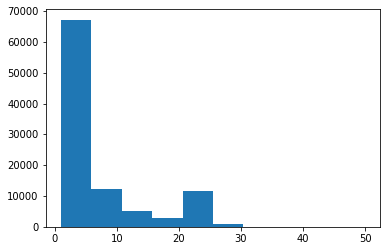

In [91]:
plt.hist(df_total["beer_id"].value_counts())

In [92]:
count_ratings = df_total["beer_id"].value_counts()
count_ratings2 = count_ratings.to_frame()
count_ratings2 = count_ratings2.reset_index()
count_ratings2.columns = ["beer_id", "Number of ratings"]
count_ratings2.head()

,beer_id,Number of ratings
0,1159,50
1,84010,50
2,94854,47
3,57162,46
4,69228,43


In [93]:
mean_rating = df_total["User_id"]

In [94]:
scores = df_total[["User_id","beer_id"]].copy()

In [95]:
scores.describe()

,User_id,beer_id
count,678042.000000,678042.000000
mean,18889.066574,50330.695028
std,10461.457343,28767.316855
min,0.000000,0.000000
25%,9745.000000,25604.000000
50%,19291.000000,50352.000000
75%,28063.000000,75259.000000
max,36136.000000,100455.000000


In [96]:
average_ratings = scores.groupby(["beer_id"]).agg(["mean"])

In [97]:
average_ratings = average_ratings.reset_index()
average_ratings.head()

,beer_id,User_id
,,mean
0,0,11184.0
1,1,6392.0
2,2,28133.0
3,3,28133.0
4,4,22586.5


In [98]:
average_ratings.columns = ["beer_id", "Mean_ratings"]

In [99]:
to_plot = average_ratings.merge(count_ratings2, how = "left", on = "beer_id")
to_plot.head()

,beer_id,Mean_ratings,Number of ratings
0,0,11184.0,7
1,1,6392.0,1
2,2,28133.0,1
3,3,28133.0,1
4,4,22586.5,2


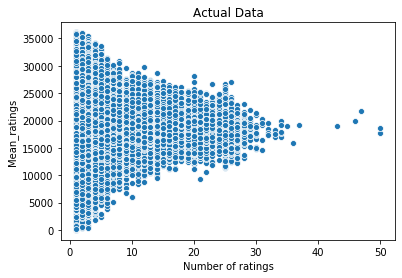

In [100]:
plt.figure()
sns.scatterplot(x = "Number of ratings", y = "Mean_ratings", data = to_plot)
plt.title("Actual Data")
plt.show()

In [101]:
predictions_total = nn.predict([df_total.User_id,df_total.beer_id,])

In [102]:
df_total.shape

(678042, 3)

In [103]:
pred = df_total[["User_id","beer_id", "ratings"]].copy()
pred.head()
pred.shape

(678042, 3)

In [104]:
pred["predicted"] = predictions_total

In [105]:
pred.columns = ["User_id","Beer_id", "actual_ratings", "predicted_ratings"]
#pred[pred["User_id"] == 999]
pred.head()

,User_id,Beer_id,actual_ratings,predicted_ratings
0,30162,84627,3.08,3.767474
1,11051,84627,3.13,3.640801
2,24945,84627,4.07,3.850411
3,30155,84627,3.38,3.546006
4,30731,84627,4.07,3.711867


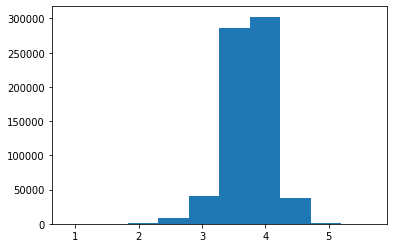

In [106]:
plt.figure()
plt.hist(pred["predicted_ratings"])
plt.show()

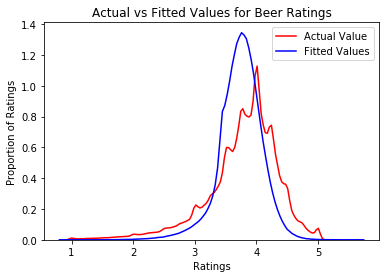

In [107]:
ax1 = sns.distplot(pred.actual_ratings, hist=False, color="r", label="Actual Value")
sns.distplot(pred.predicted_ratings, hist=False, color="b", label="Fitted Values" , ax=ax1)


plt.title('Actual vs Fitted Values for Beer Ratings')
plt.xlabel('Ratings')
plt.ylabel('Proportion of Ratings')

plt.show()
plt.close()

In [108]:
average_ratings_predicted = pred.groupby(["Beer_id"]).agg(["mean"])

In [109]:
average_ratings_predicted.head()

,User_id,actual_ratings,predicted_ratings
,mean,mean,mean
Beer_id,,,
0,11184.0,3.412857,3.481216
1,6392.0,4.260000,3.816616
2,28133.0,4.190000,3.912354
3,28133.0,3.120000,3.240651
4,22586.5,4.015000,3.769624


In [110]:
average_ratings_predicted = average_ratings_predicted.reset_index()

In [111]:
average_ratings_predicted.columns = ["beer_id", "User", "Mean_Actual", "Mean_predicted"]

In [112]:
average_ratings_predicted.drop("User", axis = 1, inplace = True)

In [113]:
average_ratings_predicted.head()

,beer_id,Mean_Actual,Mean_predicted
0,0,3.412857,3.481216
1,1,4.260000,3.816616
2,2,4.190000,3.912354
3,3,3.120000,3.240651
4,4,4.015000,3.769624


In [114]:
average_ratings_predicted = average_ratings_predicted.merge(count_ratings2, how = "left", on = "beer_id")

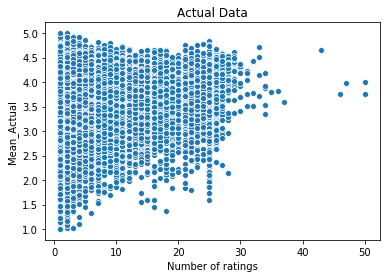

In [115]:
plt.figure()
sns.scatterplot(x = "Number of ratings", y = "Mean_Actual", data = average_ratings_predicted)
plt.title("Actual Data")
plt.show()

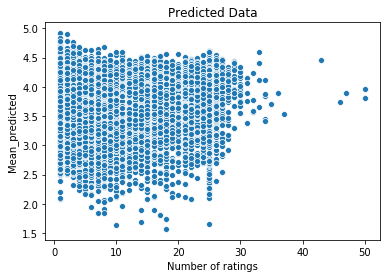

In [116]:
plt.figure()
sns.scatterplot(x = "Number of ratings", y = "Mean_predicted", data = average_ratings_predicted)
plt.title("Predicted Data")
plt.show()

### VISUALIZATIONS: EMBEDDINGS

In [117]:
from sklearn.manifold import TSNE

In [118]:
beer_r = TSNE(n_components = 3, metric = 'cosine').fit_transform(beers_for_embedding_project)

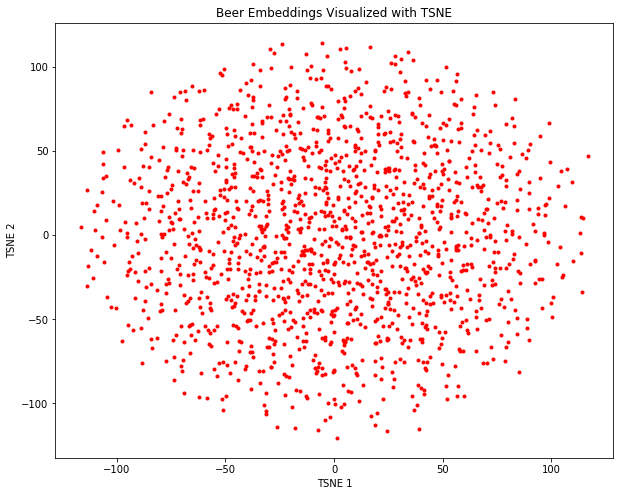

In [119]:
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = 'last'

plt.figure(figsize = (10, 8))
plt.plot(beer_r[:, 0], beer_r[:, 1], 'r.')
plt.xlabel('TSNE 1'); plt.ylabel('TSNE 2'); plt.title('Beer Embeddings Visualized with TSNE');

In [120]:
beer_n = pd.DataFrame(beer_r)

In [121]:
target = []
for beers in bc_beers_exploration["Beer name_x"]:
    target.append(beers)

In [134]:
beer_n["beer"] = target

In [126]:
styles = []
for style in bc_beers_exploration["Style"]:
    styles.append(style)

In [129]:
len(styles)

1490

In [131]:
beer_n["style"] = styles

In [135]:
beer_n.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       1490 non-null   float32
 1   1       1490 non-null   float32
 2   2       1490 non-null   float32
 3   beers   1490 non-null   object 
 4   style   1490 non-null   object 
 5   beer    1490 non-null   object 
dtypes: float32(3), object(3)
memory usage: 52.5+ KB


In [141]:
import plotly.graph_objects as go
fig = go.Figure(data=go.Scatter(x=beer_n[0],
                                y=beer_n[1],
                                mode='markers',
                                #marker_color=beer_n['beers']))
                                text=beer_n['beer'])) # hover text goes here

fig.update_layout(title='BC Beers Embeddings - TSNE')
fig.show()

In [143]:
# encoding style to see color as different beer styles
from sklearn import preprocessing
styles_unique = beer_n["style"]
styles_unique.shape

(1490,)

In [144]:
le = preprocessing.LabelEncoder()
le.fit(styles_unique)

result = le.transform(styles_unique)

In [146]:
style_df = pd.DataFrame({"style" : styles_unique, "style_code" : result})

In [147]:
style_df.head()

,style,style_code
0,French Bière de Garde,61
1,German Bock,64
2,German Bock,64
3,Belgian Pale Ale,30
4,American Adjunct Lager,0


In [148]:
beer_n["style_code"] = style_df["style_code"]

In [150]:
fig = go.Figure(data=go.Scatter(x=beer_n[0],
                                y=beer_n[1],
                                mode='markers',
                                marker_color=beer_n['style_code'],
                                text=beer_n['beer'])) # hover text goes here

fig.update_layout(title='BC Beers Embeddings by Style - TSNE')
fig.show()